# Creating Marine Environment

In [1]:
import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.registration import register, registry
import numpy as np
import pygame
import time

import math
import random
import matplotlib
import matplotlib.pyplot as plt

from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
if 'MarineEnv-v0' not in registry:
    register(
        id='MarineEnv-v0',
        entry_point='marine_env:MarineEnv',  # String reference to the class
    )

# Test the environment
env = gym.make('MarineEnv-v0')

In [3]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
Transition = namedtuple(typename='Transition', field_names=('state', 'action', 'next_state', 'reward'))

In [5]:
class ReplayMemory:
    """
    A replay buffer that stores transitions encountered by the agent.
    It enables experience replay by sampling random batches of transitions
    to break temporal correlation and improve learning stability.

    Attributes:
        capacity (int): The maximum number of transitions to store in memory.
        memory (deque): A double-ended queue to store transitions with fixed size.
    """

    def __init__(self, capacity: int):
        """
        Initializes the ReplayMemory with a fixed capacity.

        Args:
            capacity (int): The maximum number of transitions the buffer can hold.
        """
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """
        Add a transition to the memory buffer.

        Args:
            *args: The elements of a transition (state, action, reward, next_state, done),
                   which will be wrapped into a Transition namedtuple.
        """
        state, action, next_state, reward = args
        state = state.to(device)
        action = action.to(device)
        if next_state is not None:
            next_state = next_state.to(device)
        reward = reward.to(device)

        self.memory.append(Transition(state, action, next_state, reward))

    def sample(self, batch_size: int):
        """
        Randomly sample a batch of transitions from the memory buffer.

        Args:
            batch_size (int): The number of transitions to sample.

        Returns:
            List[Transition]: A list of randomly sampled transitions.
        """
        return random.sample(self.memory, batch_size)

    def __len__(self) -> int:
        """
        Return the current size of the memory buffer.

        Returns:
            int: The number of transitions currently stored in memory.
        """
        return len(self.memory)

In [6]:
class DQN(nn.Module):
    """
    A Deep Q-Network (DQN) implemented as a Multilayer Perceptron (MLP).

    The network approximates the Q-value function, which predicts the cumulative 
    reward for each possible action in a given state.

    Attributes:
        layer1 (nn.Linear): First fully connected layer (input to 128 neurons).
        layer2 (nn.Linear): Second fully connected layer (128 to 128 neurons).
        layer3 (nn.Linear): Output layer (128 to n_actions neurons).
    """

    def __init__(self, n_observations: int, n_actions: int):
        """
        Initializes the DQN network with three fully connected layers.

        Args:
            n_observations (int): The size of the input (state of the environment).
            n_actions (int): The number of possible actions in the environment.
        """
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)  # Input to hidden layer 1
        self.layer2 = nn.Linear(128, 128)  # Hidden layer 1 to hidden layer 2
        self.layer3 = nn.Linear(128, n_actions)  # Hidden layer 2 to output

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs a forward pass through the network.

        Args:
            x (torch.Tensor): The input tensor representing the state of the environment.

        Returns:
            torch.Tensor: The Q-values for each possible action.
        """
        x = F.relu(self.layer1(x))  # Apply ReLU to the first layer
        x = F.relu(self.layer2(x))  # Apply ReLU to the second layer
        return self.layer3(x)  # Output layer (no activation applied)


In [7]:
# Size of the batch sampled from the replay buffer
BATCH_SIZE = 128
# Explanation:
# The number of experiences (state-action-reward transitions) sampled from the replay buffer
# at each training step. Larger batch sizes improve stability but increase computational cost.

# Discount factor for future rewards
GAMMA = 0.99
# Explanation:
# The discount factor determines how much importance is given to future rewards.
# A value close to 1 means future rewards are highly valued, while a value closer to 0 means
# the agent focuses on immediate rewards.

# Initial value for epsilon in the epsilon-greedy policy
EPS_START = 0.9
# Explanation:
# Epsilon is the probability of choosing a random action (exploration).
# This is the starting value, meaning the agent initially explores 90% of the time.

# Final value for epsilon in the epsilon-greedy policy
EPS_END = 0.05
# Explanation:
# The minimum value epsilon can decay to. At this stage, the agent mostly exploits
# the learned policy but still explores 5% of the time to avoid getting stuck in local optima.

# Decay rate for epsilon in the epsilon-greedy policy
EPS_DECAY = 1000
# Explanation:
# The rate at which epsilon decays over time. A higher value makes epsilon decay slower,
# allowing the agent to explore for longer. The effective epsilon at time step `t` can
# be calculated as:
# epsilon(t) = EPS_END + (EPS_START - EPS_END) * exp(-t / EPS_DECAY)

# Target network soft update rate
TAU = 0.005
# Explanation:
# Determines how much the target network is updated towards the online (policy) network
# at each training step. A lower TAU makes the target network update more slowly,
# stabilizing the learning process. The update rule is:
# target_param = TAU * policy_param + (1 - TAU) * target_param

# Learning rate for the optimizer
LR = 1e-04
# Explanation:
# The step size for gradient updates during backpropagation.
# A smaller learning rate ensures slow and stable learning but may require more steps to converge.
# Too large a value may lead to instability in training.

In [8]:
# Number of actions in the environment
n_actions = env.action_space.n

# Number of state observations
state, info = env.reset()
n_observations = len(state)

# Initialize the policy and target networks
policy_net = DQN(n_observations=n_observations, n_actions=n_actions).to(device)
target_net = DQN(n_observations=n_observations, n_actions=n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())  # Copy weights from policy_net to target_net

# Optimizer for training the policy network
optimizer = optim.AdamW(policy_net.parameters(), lr=LR)

# Replay memory for experience replay
memory = ReplayMemory(10000)

# Step counter for epsilon decay
steps_done = 0


In [9]:
def select_action(state: torch.Tensor) -> torch.Tensor:
    """
    Selects an action using an epsilon-greedy policy.

    Args:
        state (torch.Tensor): The current state of the environment.

    Returns:
        torch.Tensor: The selected action as a 1x1 tensor (contains the action index).
    """
    global steps_done
    sample = random.random()  # Random number to determine explore vs exploit
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1.0 * steps_done / EPS_DECAY)
    steps_done += 1

    if sample > eps_threshold:  # Exploit: Use policy network to select the best action
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1).to(device)
    else:  # Explore: Select a random action
        return torch.tensor([[env.action_space.sample()]], dtype=torch.long, device=device)

In [10]:
episode_rewards = []  # To store cumulative rewards per episode


def plot_rewards(show_result=False):
    plt.figure(1)
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)

    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training')

    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.plot(rewards_t.numpy(), label='Episode Reward')

    # Plot moving average of the last 100 episodes
    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy(), label='100-Episode Average')

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


In [11]:
def optimize_model():
    """
    Perform one step of optimization for the policy network using the replay memory.

    The function:
        - Samples a batch of transitions from the replay memory.
        - Computes the expected Q-values for the current state-action pairs.
        - Computes the loss between the expected Q-values and the predicted Q-values.
        - Performs a backward pass to update the policy network's parameters.

    Returns:
        None
    """
    if len(memory) < BATCH_SIZE:
        return  # Exit if there are not enough samples in memory to form a batch

    # Sample a batch of transitions from the replay memory
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))  # Convert batch-array of transitions to Transition of batch-arrays

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool
    )
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model's Q-values for the current states and actions
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Initialize tensor for the next state values
    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    # Compute V(s_{t+1}) for all next states
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    # Compute expected Q-values
    expected_state_action_values = reward_batch + (GAMMA * next_state_values)

    # Compute Huber loss (Smooth L1 Loss)
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()  # Clear the gradients from the previous step
    loss.backward()  # Backpropagate the loss

    # Clip gradients to avoid exploding gradients
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), clip_value=1.0)

    # Perform a single optimization step
    optimizer.step()


In [12]:
def soft_update_target_network(policy_net, target_net, tau=0.01):
    """
    Perform a soft update of the target network parameters.

    Args:
        policy_net (nn.Module): The policy network whose parameters are used for the update.
        target_net (nn.Module): The target network to be updated.
        tau (float): The soft update coefficient. Values closer to 1.0 mean faster updates.
    """
    for target_param, policy_param in zip(target_net.parameters(), policy_net.parameters()):
        target_param.data.copy_(tau * policy_param.data + (1.0 - tau) * target_param.data)

Completed


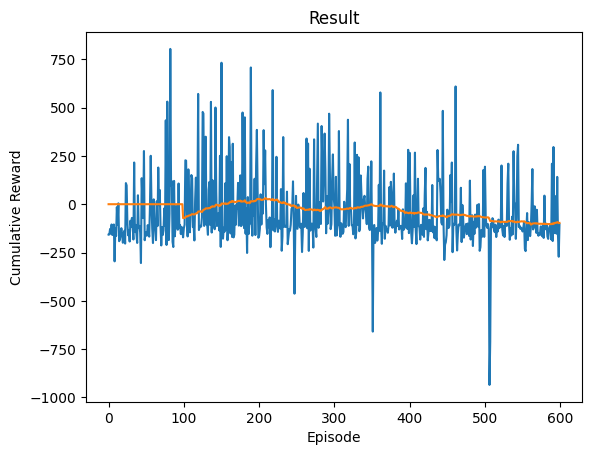

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [13]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

training = True

if training:
    env.unwrapped.sim_dt *= 50

for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    rewards = 0
    
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        rewards += reward
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # store the transition in memory
        memory.push(state, action, next_state, reward)

        # move to next state
        state = next_state

        # Update the model every N steps
        # TRAIN_EVERY = 4
        # if steps_done % TRAIN_EVERY == 0:
        optimize_model()

        # Soft update the target network
        soft_update_target_network(policy_net, target_net, tau=TAU)

        if done:
            episode_rewards.append(rewards)
            plot_rewards()
            break

print('Completed')
plot_rewards(show_result=True)
plt.ioff()
plt.show()

In [14]:
env.unwrapped.sim_dt = env.unwrapped.real_world_dt / env.unwrapped.time_scale

In [13]:
# Example usage
env = gym.make('MarineEnv-v0')
state, _ = env.reset()
done = False

while not done:
    action = env.action_space.sample()  # Random action
    state, reward, terminated, truncated, info = env.step(action)
    env.render()
    done = terminated or truncated

env.close()
print(f"Simulated Time: {info['total_sim_time']} hours")

KeyboardInterrupt: 

In [16]:
env.unwrapped.window

<Surface(600x600x32 SW)>

In [17]:
state

array([ 30.03536432, 100.30774744, 104.94340612,   6.77903313,
       169.50109272,  12.45505326])

In [18]:
lat, lon, course, speed, *rest = state

In [20]:
px, py = env.unwrapped.latlon_to_pixels(lat, lon)

In [23]:
pygame.draw.circle(env.unwrapped.window, (255, 255, 255), (px, py), 5)

<rect(364, 552, 10, 10)>

In [24]:
pygame.display.flip()

In [16]:
# Environment setup
env = gym.make('MarineEnv-v0')

# Reset the environment
state, info = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

# Run the trained policy to balance the pole
for t in range(10000):  # Maximum steps for visualization
    with torch.no_grad():
        # Use the trained policy network to select the best action
        action = policy_net(state).max(1)[1].view(1, 1).item()

    # Take the action in the environment
    next_state, reward, terminated, truncated, info = env.step(action)

    # Render the environment
    env.render()

    # Prepare the next state
    if not terminated:
        state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
    else:
        break
print(f"Simulated Time: {info['total_sim_time']} hours")
env.close()

KeyboardInterrupt: 

In [15]:
state

tensor([[ 30.4628, 100.4650, 253.4577,  13.9886,  -2.2446,  19.8086]],
       device='cuda:0')

In [19]:
policy_net(state)

tensor([[-47.3690, -46.0935, -45.2975]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
env.close()

In [17]:
policy_net(state)

tensor([[-697.2903, -694.7026, -694.3992]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

Discrete(3)

In [13]:
env = gym.make('MarineEnv-v0')

In [14]:
state, info = env.reset()

In [15]:
env.render()

Initializing pygame...
Pygame initialized.
Debug: State = [ 30.10714737 100.49428127 330.44105291   8.20380361 -20.38187919
  27.89583774], Waypoint = [ 30.38640195 100.10851504]
Debug: Vessel at pixels (593, 471)
Debug: Heading line to (513, 329)
Debug: Waypoint at pixels (130, 136)
